In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import pandas as pd


import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Datasets

MovieLens dataset: https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset

Наверное, самый часто используемый датасет.


Steam games dataset: https://www.kaggle.com/tamber/steam-video-games

Просто потому что интересно. А еще он относительно маленький, и на нем можно легко отлаживать код.

In [2]:
class RecsysDataset(Dataset):
    def __getitem__(self, index):
        pu = self.positive_users[index]
        pi = self.positive_items[index]
        nu = random.choice(list(self.item2negatives[pi]))#random.randint(0, len(self.uid_2_user)-1)
        ni = random.choice(list(self.user2negatives[pu]))#random.randint(0, len(self.iid_2_item)-1)
        return pu, pi, nu, ni
    
    def __len__(self):
        return len(self.positive_users)
    
    def get_user_relevant(self, user_id):
        return self.user2relevant[user_id]

In [3]:
class MovielensDataset(RecsysDataset):
    def __init__(self, path, rating_threshold=4.0):
        df = pd.read_csv(f"{path}/ratings.csv")
        df = df[df["rating"] >= rating_threshold]

        unique_users = df["userId"].unique()
        self.uid_2_user = dict([(i, user) for i, user in enumerate(unique_users)])
        self.user_2_uid = dict([(user, i) for i, user in enumerate(unique_users)])
        unique_items = df["movieId"].unique()
        self.iid_2_item = dict([(i, item) for i, item in enumerate(unique_items)])
        self.item_2_iid = dict([(item, i) for i, item in enumerate(unique_items)])
        movie_ds = pd.read_csv(f"{path}/movies.csv")
        id2name = list(zip(movie_ds["movieId"], movie_ds["title"]))
        self.iid_2_name = dict([(self.item_2_iid[i], name) for i, name in id2name if i in self.item_2_iid])
        self.positive_users = df["userId"].map(lambda x: self.user_2_uid[x]).to_list()
        self.positive_items = df["movieId"].map(lambda x: self.item_2_iid[x]).to_list()
        
        self.user2negatives = [set(range(len(unique_items))) for _ in unique_users]
        self.item2negatives = [set(range(len(unique_users))) for _ in unique_items]
        self.user2relevant = [[] for _ in unique_users]
        for u, i in zip(self.positive_users, self.positive_items):
            self.user2relevant[u].append(i)
            self.user2negatives[u].discard(i)
            self.item2negatives[i].discard(u)
            
    def item_by_id(self, i):
        return self.iid_2_name[i] if i in self.iid_2_name else self.iid_2_item[i]

In [4]:
class SteamDataset(RecsysDataset):
    def __init__(self, path, is_purchase=False, play_threshold=1.0):
        df = pd.read_csv(path, header=None)
        if is_purchase:
            df = df[df[2] == "purchase"]
        else:
            df = df[(df[2] == "play") & (df[3] >= play_threshold)]

        unique_users = df[0].unique()
        self.uid_2_user = dict([(i, user) for i, user in enumerate(unique_users)])
        self.user_2_uid = dict([(user, i) for i, user in enumerate(unique_users)])
        unique_items = df[1].unique()
        self.iid_2_item = dict([(i, item) for i, item in enumerate(unique_items)])
        self.item_2_iid = dict([(item, i) for i, item in enumerate(unique_items)])
        self.positive_users = df[0].map(lambda x: self.user_2_uid[x]).to_list()
        self.positive_items = df[1].map(lambda x: self.item_2_iid[x]).to_list()
        
        self.user2negatives = [set(range(len(unique_items))) for _ in unique_users]
        self.item2negatives = [set(range(len(unique_users))) for _ in unique_items]
        self.user2relevant = [[] for _ in unique_users]
        for u, i in zip(self.positive_users, self.positive_items):
            self.user2relevant[u].append(i)
            self.user2negatives[u].discard(i)
            self.item2negatives[i].discard(u)
            
    def item_by_id(self, i):
        return self.iid_2_item[i]

## Код для анализа результатов

In [5]:
def build_ranking(model, users, items, k):
    items = torch.tensor(items, dtype=torch.long).cuda()
    users = torch.tensor(users, dtype=torch.long).cuda()
    rankings = []
    with torch.no_grad():
        for u in tqdm(range(len(users))):
            user = users[u:u+1].expand_as(items)
            values = model(user, items).view(-1)
            ranking = items[torch.argsort(values, descending=True)[:k]]
            rankings.append(ranking)
    return torch.stack(rankings)

def compute_metrics(model, dataset, max_users_ctn=1024, max_items_ctn=2**15, k=10):
    # Build rankings according to model and datset
    if max_users_ctn >= len(dataset.uid_2_user):
        users = list(range(len(dataset.uid_2_user)))
    else:
        users = np.random.choice(len(dataset.uid_2_user), max_users_ctn)
    if max_items_ctn >= len(dataset.iid_2_item):
        items = list(range(len(dataset.iid_2_item)))
    else:
        items = np.random.choice(len(dataset.iid_2_item), max_items_ctn)
    ranking = build_ranking(model, users, items, k).cpu().numpy()
    
    # Compute metrics
    map_at_k = 0.
    ndcg_at_k = 0.
    for i, u in enumerate(users):
        rank = ranking[i]
        relevant = set(dataset.get_user_relevant(u))
        ap_at_k = 0.
        ctn = 0
        dcg_at_k = 0
        idcg_at_k = 0
        for j in range(k):
            if rank[j] in relevant:
                ctn += 1
                ap_at_k += ctn / (j + 1)
                dcg_at_k += 1 / np.log(j+2)
            if len(relevant) > j:
                idcg_at_k += 1 / np.log(j+2)
        ap_at_k /= min(k, max(len(relevant), 1))
        ndcg_at_k += dcg_at_k / len(users) / idcg_at_k
        map_at_k += ap_at_k / len(users)
    return {f"mAP@{k}": map_at_k, f"NDCG@{k}": ndcg_at_k}

In [13]:
def find_similars(model, item, dataset, k=20):
    with torch.no_grad():
        embs = model.item_embedding.weight
        item_emb = embs[item].unsqueeze(0).expand_as(embs)
        norm = (embs**2).sum(-1)**0.5
        dist_cos = ((embs * item_emb).sum(-1)) / norm
        dist_l2 = ((embs - item_emb)**2).sum(-1)**0.5 # L2 distance
        closest_cos = torch.argsort(dist_cos, descending=False)[1:k+1].cpu().numpy()
        closest_l2 = torch.argsort(dist_l2, descending=False)[1:k+1].cpu().numpy()
        return dataset.item_by_id(item), [dataset.item_by_id(i) for i in closest_cos], [dataset.item_by_id(i) for i in closest_l2]
    
def make_recommendations(model, user, dataset, k=20):
    items = list(range(len(dataset.iid_2_item)))
    ranking = build_ranking(model, [user], items, k).cpu().numpy()
    return [dataset.item_by_id(i) for i in ranking[0]]
    

In [7]:
def summarize_results(losses, metrics, target_item, similars_cos, similars_l2, rec):
    print("LOSS PLOT")
    plt.figure(figsize=(9,6))
    plt.plot(list(range(len(losses))), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.tight_layout()
    plt.show()
    print()
    print("METRICS")
    for k in metrics:
        print(f"{k} :: {metrics[k]}")
    print()
    print()
    print("SIMILARS (COSINE DISTANCE)")
    print(f"TARGET: {target_item}")
    for i, similar in enumerate(similars_cos):
        print(f"{i + 1}. {similar}")
    
    print()
    print("SIMILARS (L2 DISTANCE)")
    print(f"TARGET: {target_item}")
    for i, similar in enumerate(similars_l2):
        print(f"{i + 1}. {similar}")
        
    print()
    print()
    print("RECOMENDATIONS")
    for i, r in enumerate(rec):
        print(f"{i + 1}. {r}")

## Models

In [8]:
class NCF(nn.Module):
    def __init__(self, user_count, item_count, latent_size=64, hidden_size=64):
        super().__init__()
        self.user_embedding = nn.Embedding(user_count, latent_size)
        self.item_embedding = nn.Embedding(item_count, latent_size)
        self.user_mf_embedding = nn.Embedding(user_count, latent_size)
        self.item_mf_embedding = nn.Embedding(item_count, latent_size)
        self.dense_net = nn.Sequential(
            nn.Linear(2 * latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.final_layer = nn.Sequential(
            nn.Linear(hidden_size + latent_size, 1),
            nn.Sigmoid()
        )

    def forward(self, user, item):
        u = self.user_embedding(user)
        i = self.item_embedding(item)
        x = self.dense_net(torch.cat([u, i], dim=-1))
        u = self.user_mf_embedding(user)
        i = self.item_mf_embedding(item)
        y = u * i
        x = torch.cat([x, y], dim=-1)
        return self.final_layer(x)

    def compute_loss(self, y_pred, y_true):
        return F.binary_cross_entropy(y_pred, y_true)

## Train & results

In [9]:
def train_model(model, dataset, epoch=500, lr=1e-3):
    model.cuda()
    optim = Adam(model.parameters(), lr=lr)
    losses = []
    for _ in tqdm(range(epoch)):
        total_loss = 0.
        total_batches = 0.
        for batch in DataLoader(dataset, batch_size=128, num_workers=8, shuffle=True):
            pos_u, pos_i, neg_u, neg_i = batch
            pos_u = pos_u.cuda()
            pos_i = pos_i.cuda()
            neg_i = neg_i.cuda()
            #neg_u = neg_u.cuda()
            y_pred = model(pos_u, pos_i)
            pos_loss = model.compute_loss(y_pred, torch.ones_like(y_pred).float())
            y_pred = model(pos_u, neg_i)
            neg_loss = model.compute_loss(y_pred, torch.zeros_like(y_pred).float())
            #y_pred = model(neg_u, pos_i)
            #neg_loss +=model.compute_loss(y_pred, torch.zeros_like(y_pred).float())
            loss = (pos_loss + neg_loss) / 2
            optim.zero_grad()
            loss.backward()
            optim.step()
            total_loss += loss.item()
            total_batches += 1
        losses.append(total_loss / total_batches)
    metrics = compute_metrics(model, dataset, k=10)
    return losses, metrics


LOSS PLOT


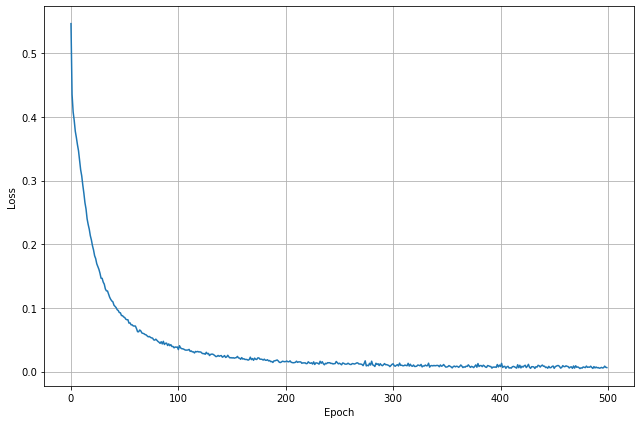


METRICS
mAP@10 :: 0.9820896948912669
NDCG@10 :: 0.9889475374877991


SIMILARS (COSINE DISTANCE)
TARGET: Fallout 4
1. Cargo Commander
2. Coffin Dodgers
3. Mishap An Accidental Haunting
4. NiGHTS into Dreams...
5. Anarchy Arcade
6. Wickland
7. The Detail
8. FootLOL Epic Fail League
9. Mad Games Tycoon
10. Killer is Dead
11. The Book of Unwritten Tales The Critter Chronicles
12. Royal Defense
13. Relic Hunters Zero
14. Deepworld
15. The Albino Hunter
16. Call to Arms
17. Pinball Arcade
18. Warhammer Online Age of Reckoning
19. Football Manager 2016 Demo
20. And Yet It Moves

SIMILARS (L2 DISTANCE)
TARGET: Fallout 4
1. Medal of Honor(TM) Single Player
2. Castle Crashers
3. Ragnarok
4. Undertale
5. Never Alone (Kisima Ingitchuna)
6. Unreal Tournament 3 Black Edition
7. Tomb Raider I
8. The LEGO Movie - Videogame
9. Dead Horde
10. RIFT
11. Hard Reset
12. Deus Ex Human Revolution - Director's Cut
13. Fuse
14. Plants vs. Zombies Game of the Year
15. The Secret of Monkey Island Special Edition

In [15]:
dataset = SteamDataset("steam-200k.csv")
model = NCF(len(dataset.uid_2_user), len(dataset.iid_2_item))
losses, metrics = train_model(model, dataset, epoch=500)
item_name, similars_cos, similars_l2 = find_similars(model, 1, dataset, k=20)
rec = make_recommendations(model, 0, dataset)
summarize_results(losses, metrics, item_name, similars_cos, similars_l2, rec)


LOSS PLOT


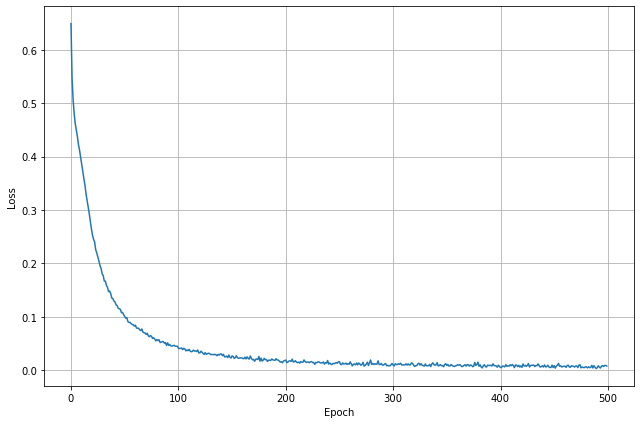


METRICS
mAP@10 :: 0.8475591889586817
NDCG@10 :: 0.9019320682547356


SIMILARS (COSINE DISTANCE)
TARGET: Toy Story (1995)
1. Jim Jefferies: I Swear to God (2009)
2. Goodbye, Mr. Chips (1939)
3. Get Him to the Greek (2010)
4. Berlin Calling (2008)
5. The Spiral Staircase (1945)
6. Gunga Din (1939)
7. Garfield: The Movie (2004)
8. Saw II (2005)
9. I, Frankenstein (2014)
10. Rent (2005)
11. Memories (Memorîzu) (1995)
12. Luzhin Defence, The (2000)
13. First Monday in October (1981)
14. Wind Rises, The (Kaze tachinu) (2013)
15. All Watched Over by Machines of Loving Grace (2011)
16. Jump In! (2007)
17. Forces of Nature (1999)
18. Paranoid Park (2007)
19. The Do-Over (2016)
20. Snatched (2017)

SIMILARS (L2 DISTANCE)
TARGET: Toy Story (1995)
1. Jurassic Park (1993)
2. Sin City (2005)
3. Demolition Man (1993)
4. Mulholland Drive (2001)
5. Horrible Bosses (2011)
6. Skyfall (2012)
7. Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
8. Three Colors: White (Trzy kolory: Bialy) (1994)
9. S

In [18]:
dataset = MovielensDataset("movielens_small")
model = NCF(len(dataset.uid_2_user), len(dataset.iid_2_item))
losses, metrics = train_model(model, dataset, epoch=500)
item_name, similars_cos, similars_l2 = find_similars(model, 0, dataset, k=20)
rec = make_recommendations(model, 0, dataset)
summarize_results(losses, metrics, item_name, similars_cos, similars_l2, rec)